# Telecom Churn Group Project

This notebook is split into following section

<b>* Common Function</b>
    * This section we have all the common functions which are used in the entire notebook
<b> * Basic Data Analysis and Null Value imputation </b>
    * Drop Columns with more than 50% NULL Values
    * Handle columns with less number of NULL Values
    * Drop columns having not informative information
    * Create Dummy Variables for the categorical variables.
    * Filter and get high valued customer information
    * Derived Columns based on basic column analysis
    * Create a new columns which will tell about the Churn/No-Churn customer and Drop 9th month related columns
<b> * EDA </b>
    * EDA for Month 6 and 7 Together
    * EDA for Month 8
    * Derived Columns by combining 6th, 7th and 8th columns 
    * How the features are varied from Good Period to Decision period
    * What is the average variation from 6th+7th Month to 8th Month
    * EDA for the derived columns
<b> * Data Modeling </b>
    * Data Normalization 
    * Basic Logistic Regression Fit to Check the accuracy
    * As churn count is less, basic logist can be done with GridSearch and K-Fold
    * Using PCA dimentionality reduction can be done
    * By taking the PCA data logistic regression can be done again with GridSearch and K-Fold to check for prediction.
    * Using Ridge Regression, It can be found the important features impacting the churn.
    * Using Tree Model, Also Important Features can be derived.
    * If during EDA, any variable relation found with multinomial relation, then SVM Kernel can be used for prediction.

<b> * Final Model Selection </b>
    * Final Model for Prediction
    * Final Model for important Feature selection 
<b> * Summary </b>
    * Project Analysis and Summary

In [521]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import time
import datetime

df = pd.read_csv('telecom_churn_data.csv')

# Common Function

In [522]:
# Function to Return Montwise ColumnsList
def returnColumnsByMonth(df):
    column_Month_6 = []
    column_Month_7 = []
    column_Month_8 = []
    column_Month_9 = []
    column_Common = []
    for eachColumns in df.columns:
        if((eachColumns.find("_6") >=0) | (eachColumns.find("jun_") >=0)):
            column_Month_6.append(eachColumns)
        elif((eachColumns.find("_7") >=0) | (eachColumns.find("jul_") >=0)):
            column_Month_7.append(eachColumns)
        elif((eachColumns.find("_8") >= 0) | (eachColumns.find("aug_") >=0)):
            column_Month_8.append(eachColumns)
        elif((eachColumns.find("_9") >=0) | (eachColumns.find("sep_") >=0)):
            column_Month_9.append(eachColumns)
        else:
            column_Common.append(eachColumns)
    return column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common

# Function to Get Columns Based on Null %
def getColumnsBasedOnNullPercent(df, nullPercentLimit, limitType = 'Upper'):
    col2NullPercent_df = pd.DataFrame(round((df.isnull().sum()/len(df.index))* 100, 2), columns=['NullPercent'])
    col2NullPercent_df = pd.DataFrame(round((df.isnull().sum()/len(df.index))* 100, 2), columns=['NullPercent'])
    if(limitType == 'Upper'):
        columnsList = np.array(col2NullPercent_df.apply(lambda x: x['NullPercent'] > nullPercentLimit , axis=1))
    if(limitType == 'Lower'):
        columnsList = np.array(col2NullPercent_df.apply(lambda x: ((x['NullPercent'] < nullPercentLimit) & (x['NullPercent'] > 0)) , axis=1))
    return np.array(df.loc[:, columnsList].columns)

# Function to get Days Since Last Recharge for 6/7/8/9 months
def daysSinceLastRechargeMonthwise(df, month):
    if(month == 6):
        return pd.to_datetime(df['last_date_of_month_6']) - pd.to_datetime(df['date_of_last_rech_6'])
    elif(month == 7):
        return pd.to_datetime(df['last_date_of_month_7']) - pd.to_datetime(df['date_of_last_rech_7'])
    elif(month == 8):
        return pd.to_datetime(df['last_date_of_month_8']) - pd.to_datetime(df['date_of_last_rech_8'])
    elif(month == 9):
        return pd.to_datetime(df['last_date_of_month_9']) - pd.to_datetime(df['date_of_last_rech_9'])

def plotCategoricalChurn_NotChurn(df, columnsList, flag = 0):
    for eachMonth in columnsList:
    #flag = 1        
    #eachMonth = "days_from_LastRechage_6"
        col = eachMonth
        X1 = df.groupby('churn')[col].agg(['mean']).reset_index()
        X1.rename(columns={'mean':col}, inplace=True)
        if(flag == 1):
            seventhMonth = eachMonth[:-1] + "7"
            X2 = df.groupby('churn')[seventhMonth].agg(['mean']).reset_index()    
            X2.rename(columns={'mean':seventhMonth}, inplace=True)
            X2 = pd.merge(X1,X2, on = ['churn'])
            newCol = eachMonth[:-1] + "goodPeriod_Avg"
            print(newCol)
            X2[newCol] = (X2[eachMonth] + X2[seventhMonth])/2
            p = sns.barplot(x='churn', y=newCol, data=X2)
            p.set_xticklabels(['Not-Churn','churn'], fontsize= 12)
            plt.ylabel(newCol,fontsize = 12)
            plt.xlabel('churn', fontsize = 12)
            plt.show()
            X2.head()

        else:
            print(eachMonth)
            p = sns.barplot(x='churn', y=col, data=X1)
            p.set_xticklabels(['Not-Churn','churn'], fontsize= 12)
            plt.ylabel(col,fontsize = 12)
            plt.xlabel('churn', fontsize = 12)
            plt.show()
            X1.head()

# Basic Data Analysis and Null Value Imputation

In [523]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [524]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

####  * Get Columns Monthwise & Basic Understanding of Columns

In [525]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))

Month 6 Columns Count ==> 55
Month 7 Columns Count ==> 55
Month 8 Columns Count ==> 55
Month 9 Columns Count ==> 55
Common Columns Count ==> 6


In [526]:
# All Months are having same type of columns So lets see the columns in general
print ("\nMonth based Columns:\n \t\t==> {}".format(np.array(column_Month_6)))
print ("\nCommon Columns:\n \t\t==> {}".format(np.array(column_Common)))


Month based Columns:
 		==> ['last_date_of_month_6' 'arpu_6' 'onnet_mou_6' 'offnet_mou_6'
 'roam_ic_mou_6' 'roam_og_mou_6' 'loc_og_t2t_mou_6' 'loc_og_t2m_mou_6'
 'loc_og_t2f_mou_6' 'loc_og_t2c_mou_6' 'loc_og_mou_6' 'std_og_t2t_mou_6'
 'std_og_t2m_mou_6' 'std_og_t2f_mou_6' 'std_og_t2c_mou_6' 'std_og_mou_6'
 'isd_og_mou_6' 'spl_og_mou_6' 'og_others_6' 'total_og_mou_6'
 'loc_ic_t2t_mou_6' 'loc_ic_t2m_mou_6' 'loc_ic_t2f_mou_6' 'loc_ic_mou_6'
 'std_ic_t2t_mou_6' 'std_ic_t2m_mou_6' 'std_ic_t2f_mou_6'
 'std_ic_t2o_mou_6' 'std_ic_mou_6' 'total_ic_mou_6' 'spl_ic_mou_6'
 'isd_ic_mou_6' 'ic_others_6' 'total_rech_num_6' 'total_rech_amt_6'
 'max_rech_amt_6' 'date_of_last_rech_6' 'last_day_rch_amt_6'
 'date_of_last_rech_data_6' 'total_rech_data_6' 'max_rech_data_6'
 'count_rech_2g_6' 'count_rech_3g_6' 'av_rech_amt_data_6' 'vol_2g_mb_6'
 'vol_3g_mb_6' 'arpu_3g_6' 'arpu_2g_6' 'night_pck_user_6' 'monthly_2g_6'
 'sachet_2g_6' 'monthly_3g_6' 'sachet_3g_6' 'fb_user_6' 'jun_vbc_3g']

Common Columns:
 		==

#### * Derive Columns Total_Recharge_Amount from 6th and 7th Month total_rech_amt

In [527]:
df['Total_Recharge_Amount'] = df['total_rech_amt_6'] + df['total_rech_amt_7']

# Get 70% of "Total Recharge Amount" to identify the recharge Amount Range for High value customer
print(df['Total_Recharge_Amount'].describe(percentiles = [0.7]))
print("\n70% of Total Recharge Amount of first 2 months are {}".format(df['Total_Recharge_Amount'].describe(percentiles = [0.7])[5]))

count    99999.000000
mean       650.477585
std        741.666932
min          0.000000
50%        458.000000
70%        737.000000
max      75525.000000
Name: Total_Recharge_Amount, dtype: float64

70% of Total Recharge Amount of first 2 months are 737.0


#### * Filter High Value Customer from main data frame

In [528]:
df = df[df['Total_Recharge_Amount'] > 737].reset_index(drop=True)
print("\nTotal High Value Customer Count ==> {}".format(df.shape[0]))
df.drop(columns=['Total_Recharge_Amount'], inplace=True)


Total High Value Customer Count ==> 29979


#### * Null Value Checking and Drop High Null Value Columns

In [529]:
#Get Null Percentage in dataFrame and Filter
nullPercentageLimit = 50
columns_More_Than_50_PercentNull = getColumnsBasedOnNullPercent(df,nullPercentageLimit)
#Drop Columns with More than 50% NUll
df = df.loc[:, ~df.columns.isin(columns_More_Than_50_PercentNull)]

print("\nColumn List Dropped with More than 50% of Null Value:==>\n {}\n".format(columns_More_Than_50_PercentNull))


Column List Dropped with More than 50% of Null Value:==>
 ['date_of_last_rech_data_6' 'date_of_last_rech_data_7'
 'date_of_last_rech_data_8' 'date_of_last_rech_data_9' 'total_rech_data_6'
 'total_rech_data_7' 'total_rech_data_8' 'total_rech_data_9'
 'max_rech_data_6' 'max_rech_data_7' 'max_rech_data_8' 'max_rech_data_9'
 'count_rech_2g_6' 'count_rech_2g_7' 'count_rech_2g_8' 'count_rech_2g_9'
 'count_rech_3g_6' 'count_rech_3g_7' 'count_rech_3g_8' 'count_rech_3g_9'
 'av_rech_amt_data_6' 'av_rech_amt_data_7' 'av_rech_amt_data_8'
 'av_rech_amt_data_9' 'arpu_3g_6' 'arpu_3g_7' 'arpu_3g_8' 'arpu_3g_9'
 'arpu_2g_6' 'arpu_2g_7' 'arpu_2g_8' 'arpu_2g_9' 'night_pck_user_6'
 'night_pck_user_7' 'night_pck_user_8' 'night_pck_user_9' 'fb_user_6'
 'fb_user_7' 'fb_user_8' 'fb_user_9']



#### * Check Categorical Variables and Single Record Variables

In [530]:
singleCategoryColumns = df.loc[:, np.array(df.apply(lambda x: x.nunique() == 1))].columns
for eachSingleCatgory in singleCategoryColumns:
    print("{}: {}".format(eachSingleCatgory, df[eachSingleCatgory].unique()))
print("\n<=== Drop Single Category Columns, Other than last_date_of_month_6/7/8/9, as it will be used for Derive Columns ===>\n")
singleCategoryColumns = [x for x in singleCategoryColumns if x not in list(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9'])]
singleCategoryColumns = np.array(singleCategoryColumns)
df = df.loc[:, ~df.columns.isin(singleCategoryColumns)]
df['last_date_of_month_7'] = df['last_date_of_month_7'].fillna('7/31/2014')
df['last_date_of_month_8'] = df['last_date_of_month_8'].fillna('8/31/2014')
df['last_date_of_month_9'] = df['last_date_of_month_9'].fillna('9/30/2014')

circle_id: [109]
loc_og_t2o_mou: [ 0. nan]
std_og_t2o_mou: [ 0. nan]
loc_ic_t2o_mou: [ 0. nan]
last_date_of_month_6: ['6/30/2014']
last_date_of_month_7: ['7/31/2014' nan]
last_date_of_month_8: ['8/31/2014' nan]
last_date_of_month_9: ['9/30/2014' nan]
std_og_t2c_mou_6: [ 0. nan]
std_og_t2c_mou_7: [ 0. nan]
std_og_t2c_mou_8: [ 0. nan]
std_og_t2c_mou_9: [nan  0.]
std_ic_t2o_mou_6: [ 0. nan]
std_ic_t2o_mou_7: [ 0. nan]
std_ic_t2o_mou_8: [ 0. nan]
std_ic_t2o_mou_9: [nan  0.]

<=== Drop Single Category Columns, Other than last_date_of_month_6/7/8/9, as it will be used for Derive Columns ===>



#### * Analyze Null Value for Less than 50%

In [531]:
columns_Less_Than_50_PercentNull = getColumnsBasedOnNullPercent(df,nullPercentageLimit, limitType='Lower')
df_temp = df.loc[:, columns_Less_Than_50_PercentNull]
round(df_temp.isnull().sum()/len(df_temp.index) * 100,2)

onnet_mou_6            1.05
onnet_mou_7            1.01
onnet_mou_8            3.13
onnet_mou_9            5.68
offnet_mou_6           1.05
offnet_mou_7           1.01
offnet_mou_8           3.13
offnet_mou_9           5.68
roam_ic_mou_6          1.05
roam_ic_mou_7          1.01
roam_ic_mou_8          3.13
roam_ic_mou_9          5.68
roam_og_mou_6          1.05
roam_og_mou_7          1.01
roam_og_mou_8          3.13
roam_og_mou_9          5.68
loc_og_t2t_mou_6       1.05
loc_og_t2t_mou_7       1.01
loc_og_t2t_mou_8       3.13
loc_og_t2t_mou_9       5.68
loc_og_t2m_mou_6       1.05
loc_og_t2m_mou_7       1.01
loc_og_t2m_mou_8       3.13
loc_og_t2m_mou_9       5.68
loc_og_t2f_mou_6       1.05
loc_og_t2f_mou_7       1.01
loc_og_t2f_mou_8       3.13
loc_og_t2f_mou_9       5.68
loc_og_t2c_mou_6       1.05
loc_og_t2c_mou_7       1.01
                       ... 
std_ic_t2t_mou_8       3.13
std_ic_t2t_mou_9       5.68
std_ic_t2m_mou_6       1.05
std_ic_t2m_mou_7       1.01
std_ic_t2m_mou_8    

#### * As the Null % is very less, lets see if Null Value Can be imputed with some value

In [532]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df_temp)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))
print("==> All Months are having same columns with less% of Null Value")
print(np.array(column_Month_7))
df_temp.loc[:, column_Month_7].head()

Month 6 Columns Count ==> 28
Month 7 Columns Count ==> 28
Month 8 Columns Count ==> 28
Month 9 Columns Count ==> 28
Common Columns Count ==> 0
==> All Months are having same columns with less% of Null Value
['onnet_mou_7' 'offnet_mou_7' 'roam_ic_mou_7' 'roam_og_mou_7'
 'loc_og_t2t_mou_7' 'loc_og_t2m_mou_7' 'loc_og_t2f_mou_7'
 'loc_og_t2c_mou_7' 'loc_og_mou_7' 'std_og_t2t_mou_7' 'std_og_t2m_mou_7'
 'std_og_t2f_mou_7' 'std_og_mou_7' 'isd_og_mou_7' 'spl_og_mou_7'
 'og_others_7' 'loc_ic_t2t_mou_7' 'loc_ic_t2m_mou_7' 'loc_ic_t2f_mou_7'
 'loc_ic_mou_7' 'std_ic_t2t_mou_7' 'std_ic_t2m_mou_7' 'std_ic_t2f_mou_7'
 'std_ic_mou_7' 'spl_ic_mou_7' 'isd_ic_mou_7' 'ic_others_7'
 'date_of_last_rech_7']


,onnet_mou_7,offnet_mou_7,roam_ic_mou_7,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,std_og_t2t_mou_7,...,loc_ic_t2f_mou_7,loc_ic_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7,std_ic_mou_7,spl_ic_mou_7,isd_ic_mou_7,ic_others_7,date_of_last_rech_7
0,54.68,567.16,33.49,12.59,31.38,447.38,55.14,0.0,533.91,23.29,...,101.46,355.23,11.83,126.99,34.24,173.08,0.0,14.53,15.19,7/25/2014
1,351.03,80.63,0.00,0.00,217.59,70.58,0.00,0.0,288.18,133.43,...,0.00,23.83,0.58,4.08,0.00,4.66,0.0,0.00,0.00,7/31/2014
2,108.39,119.28,144.24,35.26,6.19,47.28,0.00,0.0,53.48,85.98,...,0.00,26.11,38.29,29.79,0.00,68.09,0.0,62.11,16.24,7/22/2014
3,74.01,229.74,2.83,17.74,65.16,145.99,4.48,0.0,215.64,2.58,...,8.68,229.83,78.64,73.08,0.00,151.73,0.0,0.00,0.00,7/31/2014
4,9.28,0.00,4.76,8.46,0.00,0.00,0.00,0.0,0.00,0.81,...,0.00,2.31,0.00,0.00,0.00,0.00,0.0,0.00,0.00,7/30/2014


#### * One derive column for each month from the date columns and drop the date column, then impute NULL for derive column with 30 days

In [533]:
# 4 Derive Columns for each month, which will tell before how many days from month end, recahrge happened by subscriber.
df['days_from_LastRechage_6'] = daysSinceLastRechargeMonthwise(df, 6).apply(lambda x: x.days)
df['days_from_LastRechage_7'] = daysSinceLastRechargeMonthwise(df, 7).apply(lambda x: x.days)
df['days_from_LastRechage_8'] = daysSinceLastRechargeMonthwise(df, 8).apply(lambda x: x.days)
df['days_from_LastRechage_9'] = daysSinceLastRechargeMonthwise(df, 9).apply(lambda x: x.days)
df['days_from_LastRechage_6'] = df['days_from_LastRechage_6'].fillna(30)
df['days_from_LastRechage_7'] = df['days_from_LastRechage_7'].fillna(30)
df['days_from_LastRechage_8'] = df['days_from_LastRechage_8'].fillna(30)
df['days_from_LastRechage_9'] = df['days_from_LastRechage_9'].fillna(30)

In [534]:
#Drop the last Recharge Date and End date of the month columns for all the months
dateColumns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8','last_date_of_month_9',
              'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']
df = df.loc[:, ~df.columns.isin(dateColumns)]

#### * Fill Other NULL field with value 0 (Need to check further if any special logic need to put)

In [535]:
df = df.fillna(0)
df.reset_index()

,index,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,...,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_from_LastRechage_6,days_from_LastRechage_7,days_from_LastRechage_8,days_from_LastRechage_9
0,0,7000701601,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,0.00,...,0,802,57.74,19.38,18.74,0.00,3.0,6.0,5.0,0.0
1,1,7001524846,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,...,0,315,21.03,910.65,122.16,0.00,5.0,0.0,1.0,0.0
2,2,7002191713,492.846,205.671,593.260,322.732,501.76,108.39,534.24,244.81,...,0,2607,0.00,0.00,0.00,0.00,10.0,9.0,1.0,4.0
3,3,7000875565,430.975,299.869,187.894,206.490,50.51,74.01,70.61,31.34,...,0,511,0.00,2.45,21.89,0.00,0.0,0.0,17.0,20.0
4,4,7000187447,690.008,18.980,25.499,257.583,1185.91,9.28,7.79,558.51,...,0,667,0.00,0.00,0.00,0.00,0.0,1.0,6.0,1.0
5,5,7002124215,514.453,597.753,637.760,578.596,102.41,132.11,85.14,161.63,...,0,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
6,6,7001125315,422.050,359.730,354.793,473.030,124.19,55.19,141.11,138.04,...,0,3072,0.00,0.00,0.00,0.00,7.0,14.0,0.0,1.0
7,7,7000149764,977.020,2362.833,409.230,799.356,0.00,0.00,0.00,0.00,...,0,1328,358.10,2706.83,1714.67,0.00,0.0,1.0,5.0,2.0
8,8,7000815202,363.987,486.558,393.909,391.709,248.99,619.96,666.38,494.79,...,0,1155,0.00,0.00,0.00,0.00,0.0,3.0,7.0,4.0
9,9,7000721289,482.832,425.764,229.769,143.596,86.39,118.88,80.44,40.06,...,0,2010,0.00,0.00,0.00,0.00,6.0,9.0,0.0,13.0


In [536]:
column_Month_6, column_Month_7, column_Month_8, column_Month_9, column_Common = returnColumnsByMonth(df)

print("Month 6 Columns Count ==> {}".format(len(column_Month_6)))
print("Month 7 Columns Count ==> {}".format(len(column_Month_7)))
print("Month 8 Columns Count ==> {}".format(len(column_Month_8)))
print("Month 9 Columns Count ==> {}".format(len(column_Month_9)))
print("Common Columns Count ==> {}".format(len(column_Common)))
print("==> All Months are having same columns with less% of Null Value")
print(np.array(column_Month_7))
df.loc[:, column_Month_7].head()

Month 6 Columns Count ==> 42
Month 7 Columns Count ==> 42
Month 8 Columns Count ==> 42
Month 9 Columns Count ==> 42
Common Columns Count ==> 2
==> All Months are having same columns with less% of Null Value
['arpu_7' 'onnet_mou_7' 'offnet_mou_7' 'roam_ic_mou_7' 'roam_og_mou_7'
 'loc_og_t2t_mou_7' 'loc_og_t2m_mou_7' 'loc_og_t2f_mou_7'
 'loc_og_t2c_mou_7' 'loc_og_mou_7' 'std_og_t2t_mou_7' 'std_og_t2m_mou_7'
 'std_og_t2f_mou_7' 'std_og_mou_7' 'isd_og_mou_7' 'spl_og_mou_7'
 'og_others_7' 'total_og_mou_7' 'loc_ic_t2t_mou_7' 'loc_ic_t2m_mou_7'
 'loc_ic_t2f_mou_7' 'loc_ic_mou_7' 'std_ic_t2t_mou_7' 'std_ic_t2m_mou_7'
 'std_ic_t2f_mou_7' 'std_ic_mou_7' 'total_ic_mou_7' 'spl_ic_mou_7'
 'isd_ic_mou_7' 'ic_others_7' 'total_rech_num_7' 'total_rech_amt_7'
 'max_rech_amt_7' 'last_day_rch_amt_7' 'vol_2g_mb_7' 'vol_3g_mb_7'
 'monthly_2g_7' 'sachet_2g_7' 'monthly_3g_7' 'sachet_3g_7' 'jul_vbc_3g'
 'days_from_LastRechage_7']


,arpu_7,onnet_mou_7,offnet_mou_7,roam_ic_mou_7,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,...,max_rech_amt_7,last_day_rch_amt_7,vol_2g_mb_7,vol_3g_mb_7,monthly_2g_7,sachet_2g_7,monthly_3g_7,sachet_3g_7,jul_vbc_3g,days_from_LastRechage_7
0,1349.850,54.68,567.16,33.49,12.59,31.38,447.38,55.14,0.0,533.91,...,790,0,0.0,0.00,0,0,0,0,19.38,6.0
1,492.223,351.03,80.63,0.00,0.00,217.59,70.58,0.00,0.0,288.18,...,154,0,356.0,750.95,1,1,0,0,910.65,0.0
2,205.671,108.39,119.28,144.24,35.26,6.19,47.28,0.00,0.0,53.48,...,110,50,0.0,0.00,0,0,0,0,0.00,9.0
3,299.869,74.01,229.74,2.83,17.74,65.16,145.99,4.48,0.0,215.64,...,110,100,0.0,0.00,0,0,0,0,2.45,0.0
4,18.980,9.28,0.00,4.76,8.46,0.00,0.00,0.00,0.0,0.00,...,0,0,0.0,0.00,0,0,0,0,0.00,1.0


#### * Derive a Column which will tell if subscriber is churn or not churn

In [537]:
# Label churn and non-churn customers
df['churn'] = np.where(
            (
                (df['total_ic_mou_9'] == 0.0) | 
                (df['total_og_mou_9'] == 0.0)
            ) & 
            (
                (df['vol_2g_mb_9'] == 0.0) & 
                (df['vol_3g_mb_9'] == 0.0)
            ),1,0
        )

# EDA and Derive Columns

#### * EDA For Month 6 Feature (Good Period)

arpu_6


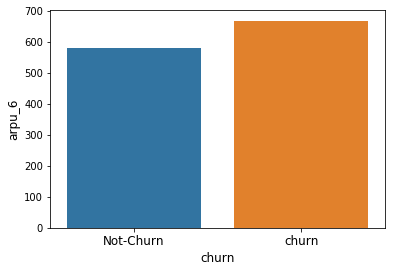

onnet_mou_6


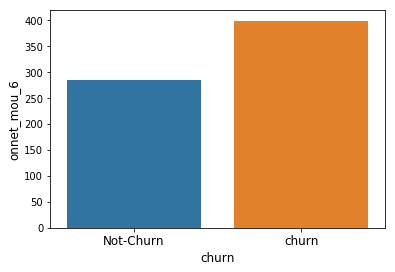

offnet_mou_6


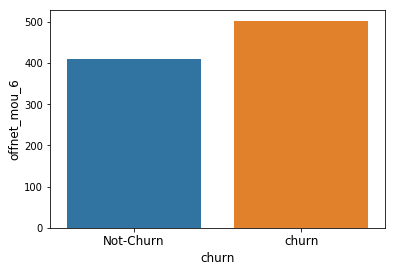

roam_ic_mou_6


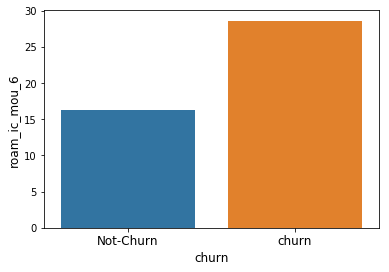

roam_og_mou_6


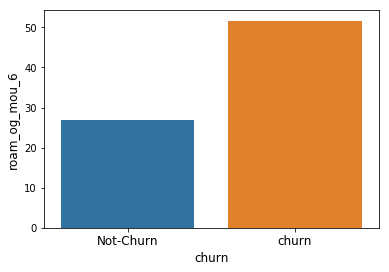

loc_og_t2t_mou_6


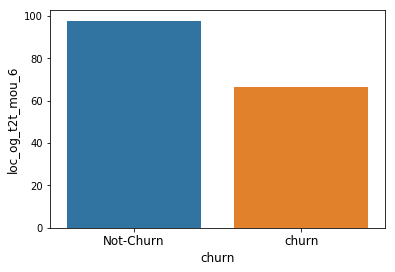

loc_og_t2m_mou_6


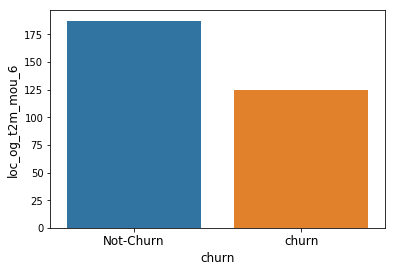

loc_og_t2f_mou_6


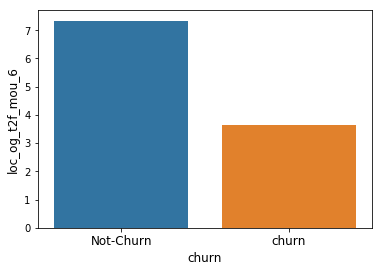

loc_og_t2c_mou_6


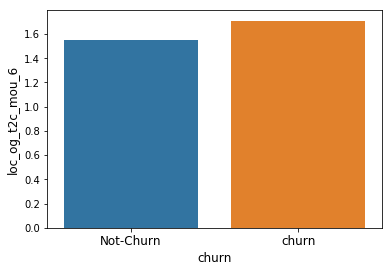

loc_og_mou_6


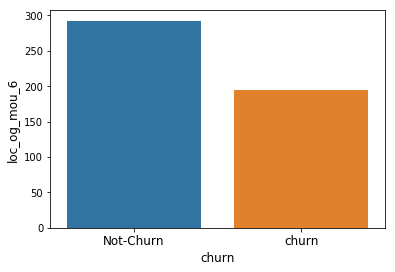

std_og_t2t_mou_6


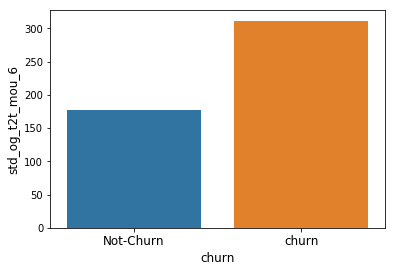

std_og_t2m_mou_6


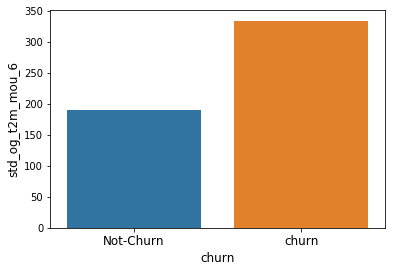

std_og_t2f_mou_6


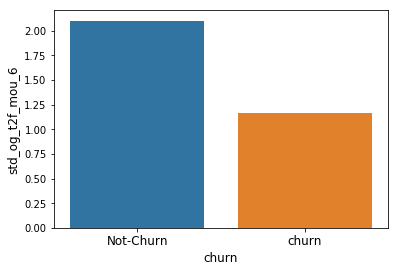

std_og_mou_6


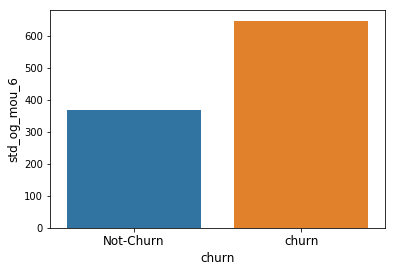

isd_og_mou_6


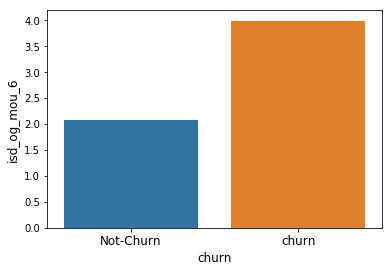

spl_og_mou_6


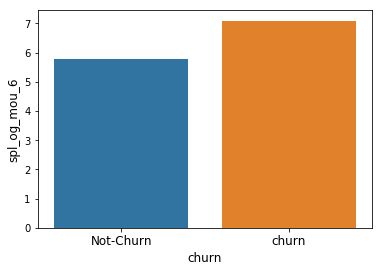

og_others_6


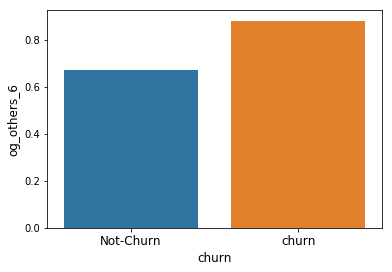

total_og_mou_6


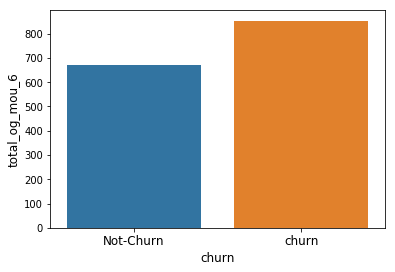

loc_ic_t2t_mou_6


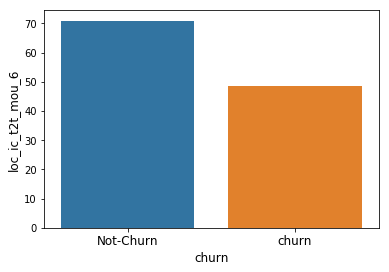

loc_ic_t2m_mou_6


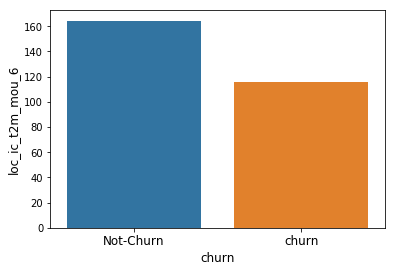

loc_ic_t2f_mou_6


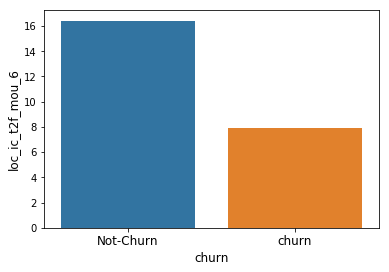

loc_ic_mou_6


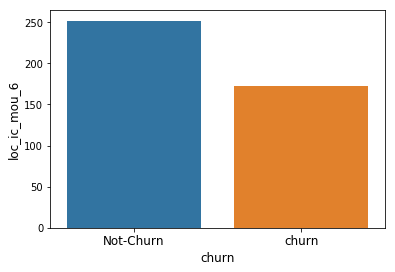

std_ic_t2t_mou_6


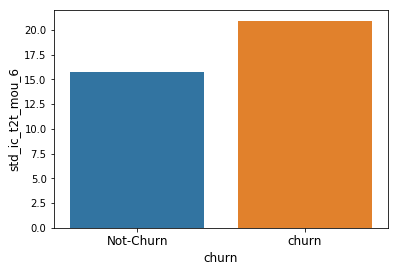

std_ic_t2m_mou_6


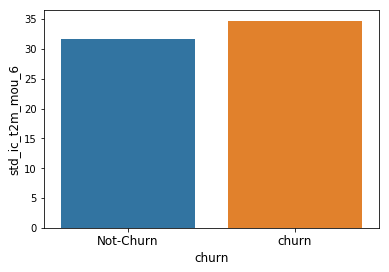

std_ic_t2f_mou_6


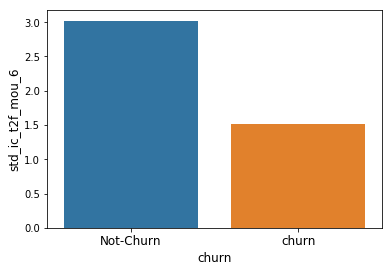

std_ic_mou_6


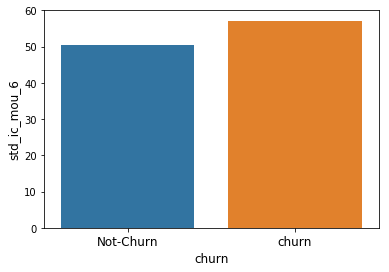

total_ic_mou_6


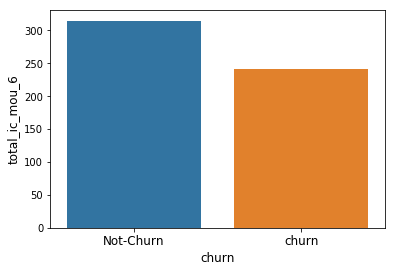

spl_ic_mou_6


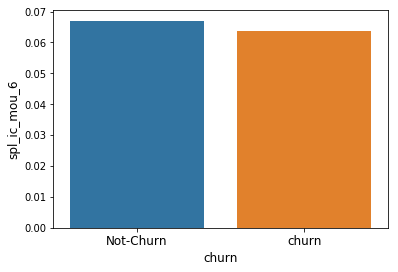

isd_ic_mou_6


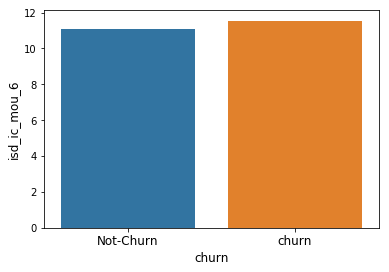

ic_others_6


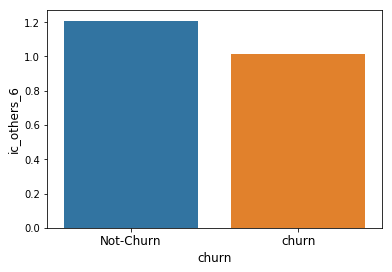

total_rech_num_6


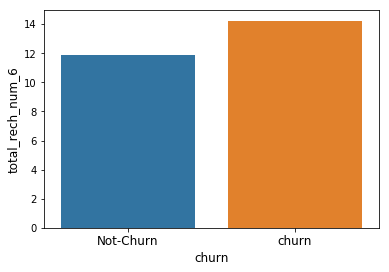

total_rech_amt_6


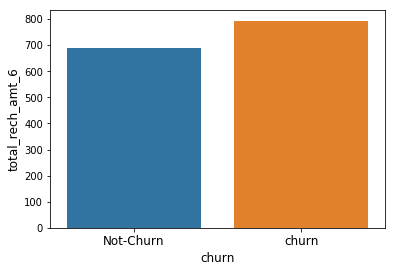

max_rech_amt_6


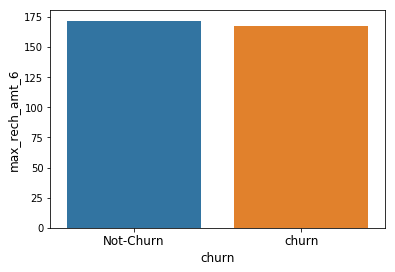

last_day_rch_amt_6


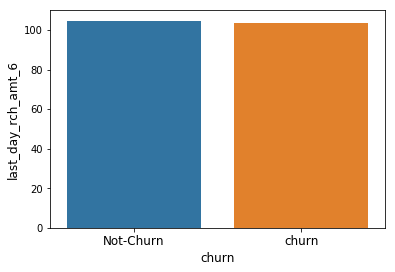

vol_2g_mb_6


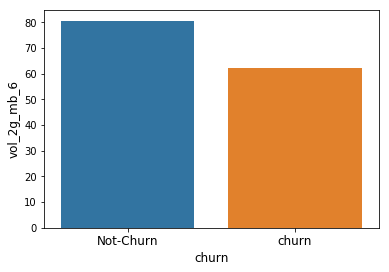

vol_3g_mb_6


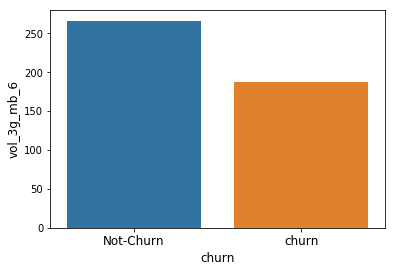

monthly_2g_6


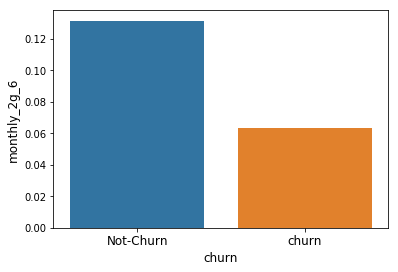

sachet_2g_6


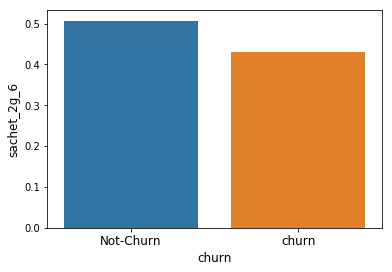

monthly_3g_6


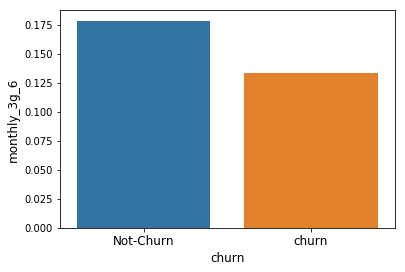

sachet_3g_6


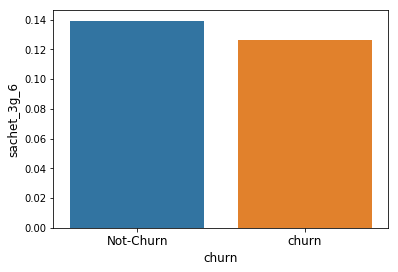

jun_vbc_3g


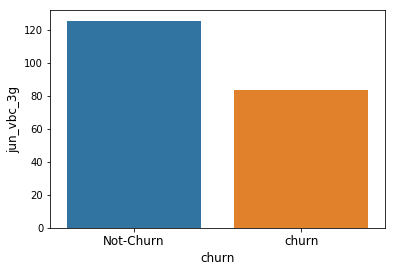

days_from_LastRechage_6


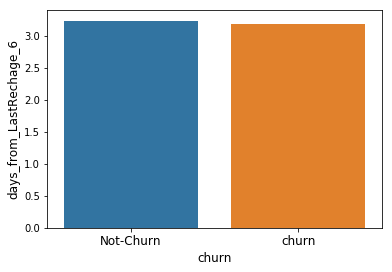

In [539]:
#EDA For Month6 Columns
plotCategoricalChurn_NotChurn(df, column_Month_6)

#### * EDA For Month 7 features (Good Period)

arpu_7


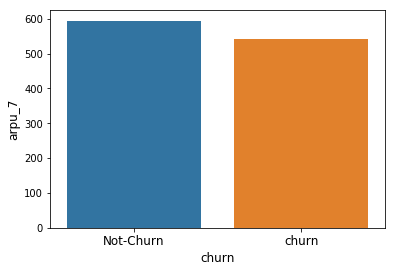

onnet_mou_7


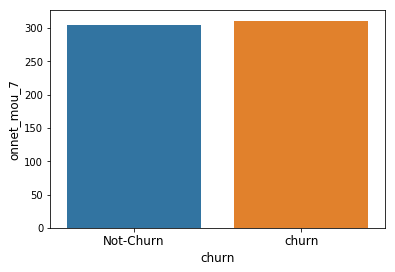

offnet_mou_7


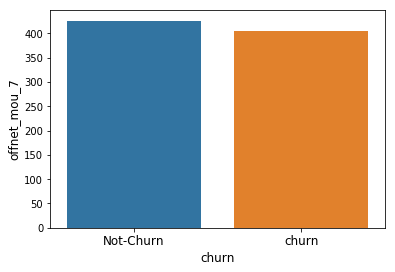

roam_ic_mou_7


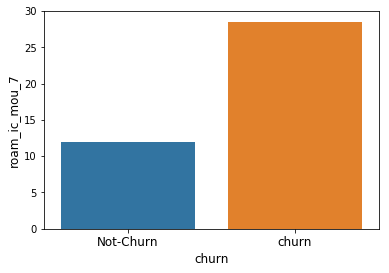

roam_og_mou_7


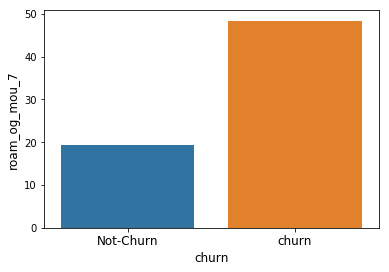

loc_og_t2t_mou_7


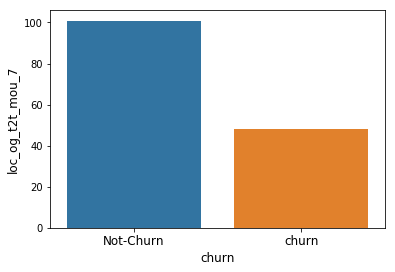

loc_og_t2m_mou_7


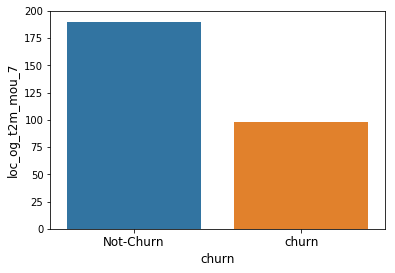

loc_og_t2f_mou_7


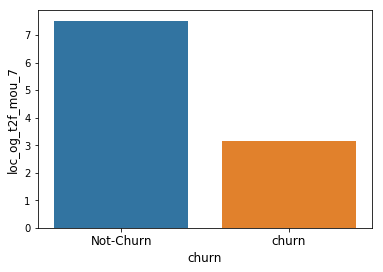

loc_og_t2c_mou_7


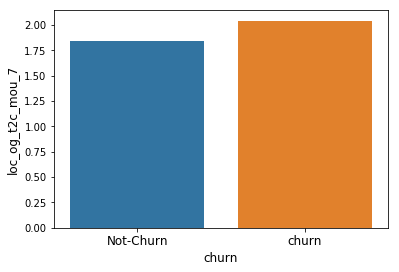

loc_og_mou_7


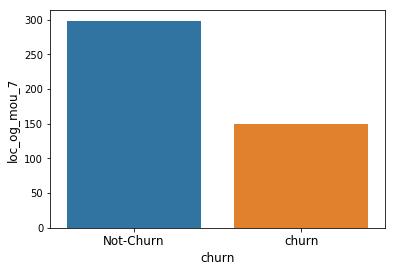

std_og_t2t_mou_7


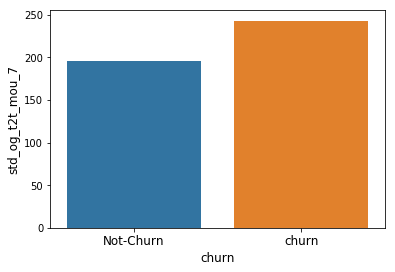

std_og_t2m_mou_7


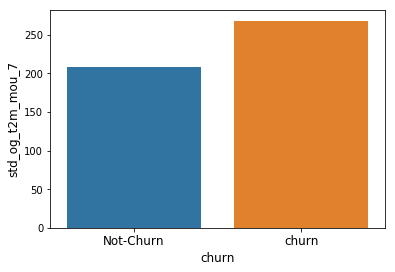

std_og_t2f_mou_7


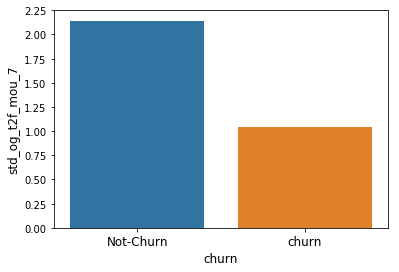

std_og_mou_7


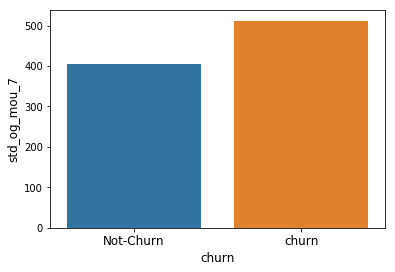

isd_og_mou_7


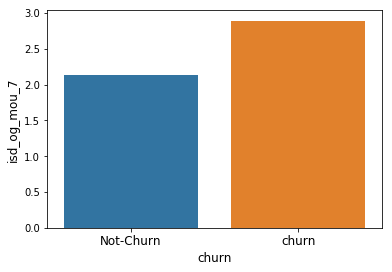

spl_og_mou_7


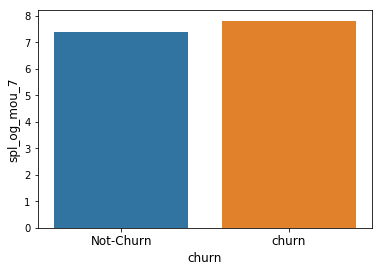

og_others_7


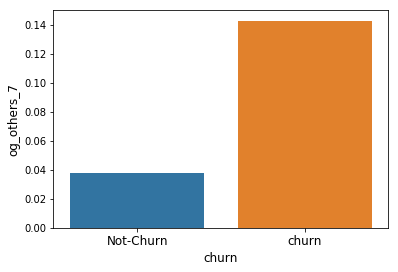

total_og_mou_7


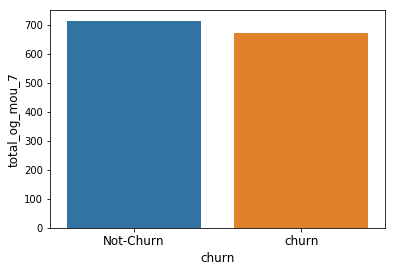

loc_ic_t2t_mou_7


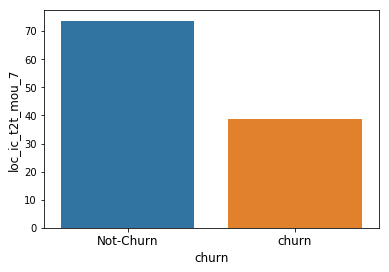

loc_ic_t2m_mou_7


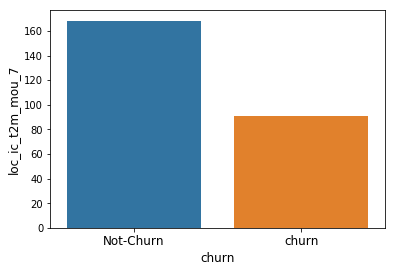

loc_ic_t2f_mou_7


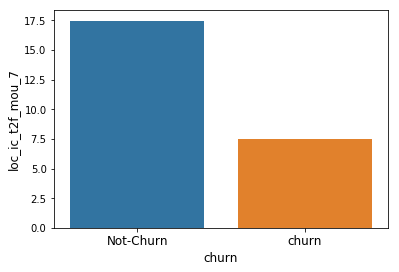

loc_ic_mou_7


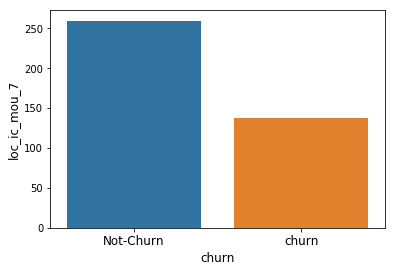

std_ic_t2t_mou_7


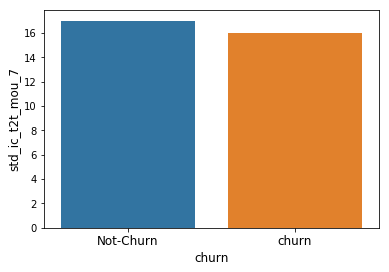

std_ic_t2m_mou_7


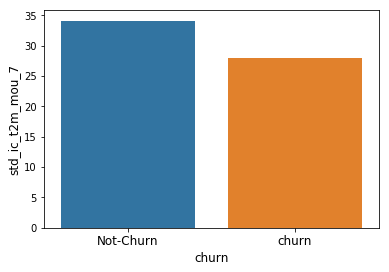

std_ic_t2f_mou_7


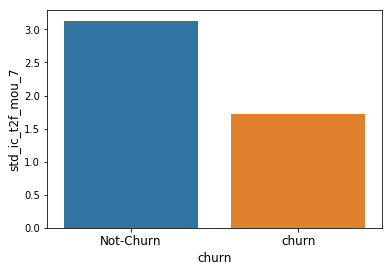

std_ic_mou_7


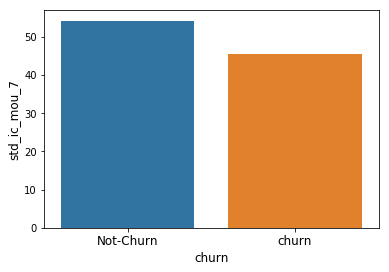

total_ic_mou_7


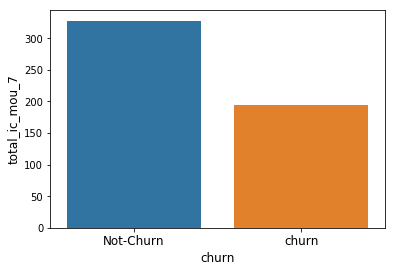

spl_ic_mou_7


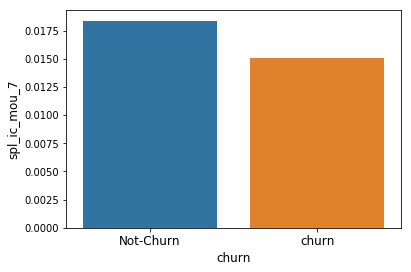

isd_ic_mou_7


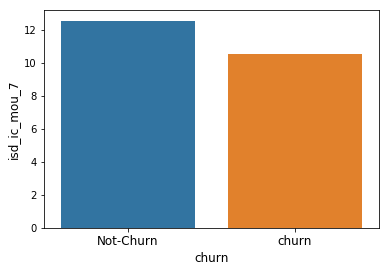

ic_others_7


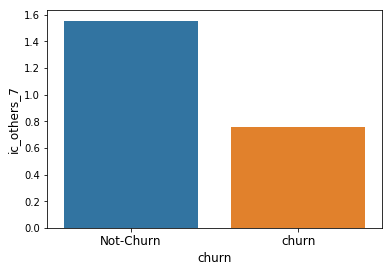

total_rech_num_7


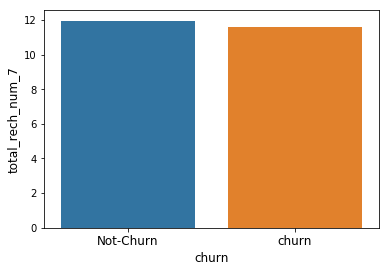

total_rech_amt_7


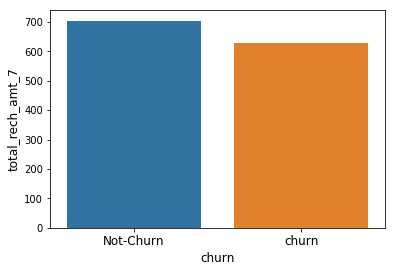

max_rech_amt_7


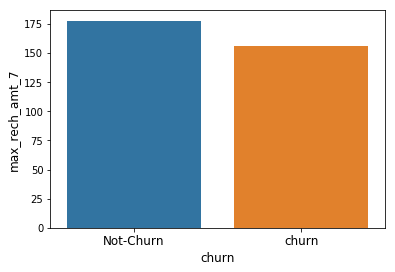

last_day_rch_amt_7


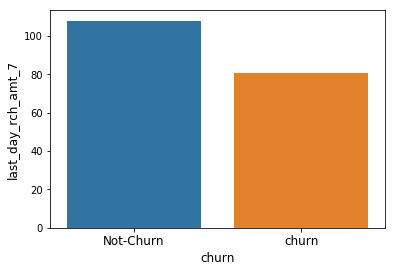

vol_2g_mb_7


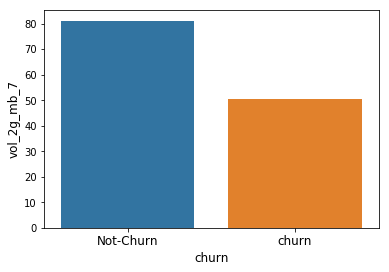

vol_3g_mb_7


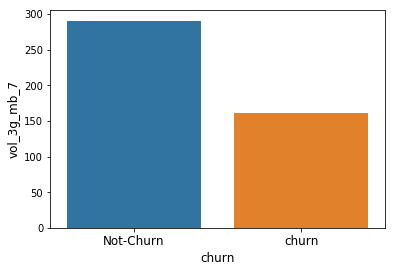

monthly_2g_7


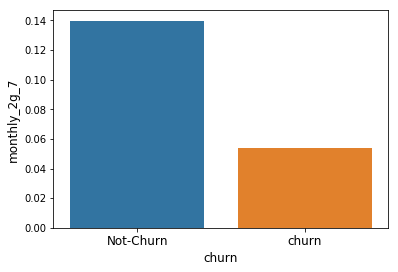

sachet_2g_7


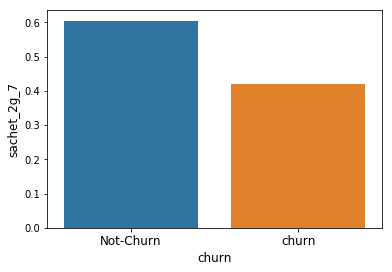

monthly_3g_7


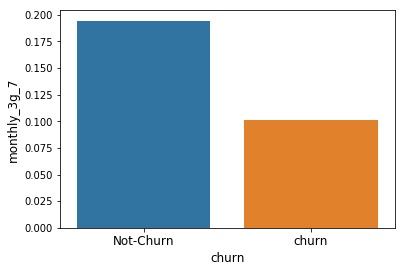

sachet_3g_7


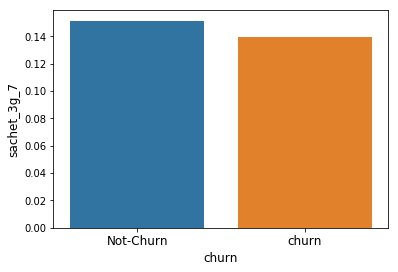

jul_vbc_3g


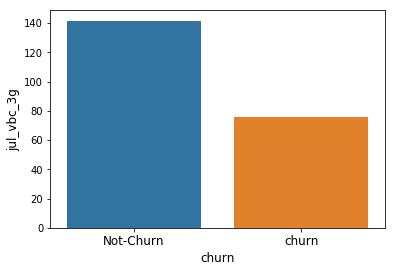

days_from_LastRechage_7


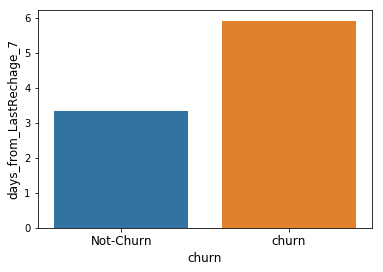

In [540]:
#EDA For Month7 Columns
plotCategoricalChurn_NotChurn(df, column_Month_7)

#### * EDA For Month 8 Feature (Decision Month)

arpu_8


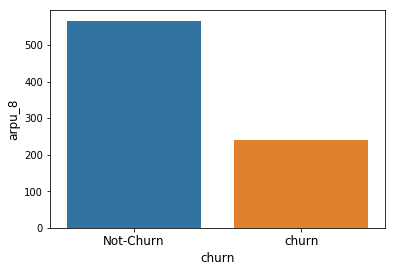

onnet_mou_8


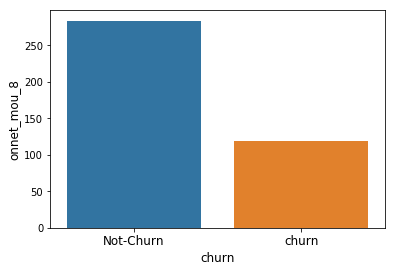

offnet_mou_8


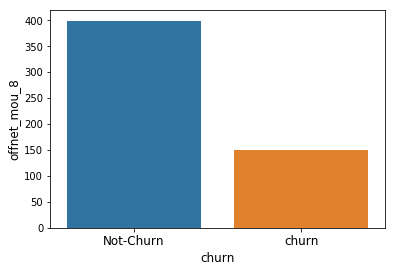

roam_ic_mou_8


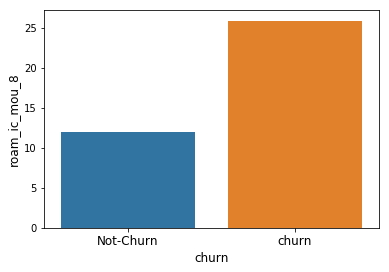

roam_og_mou_8


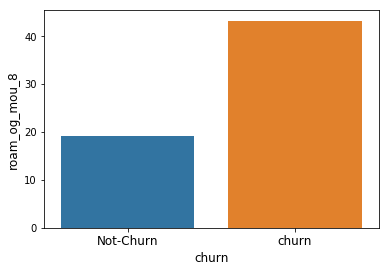

loc_og_t2t_mou_8


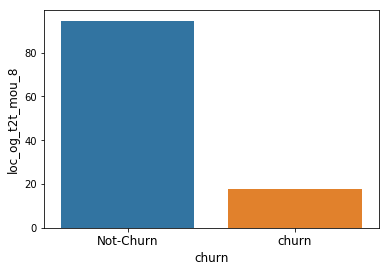

loc_og_t2m_mou_8


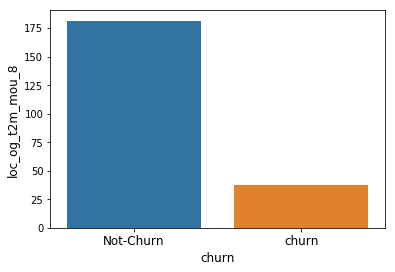

loc_og_t2f_mou_8


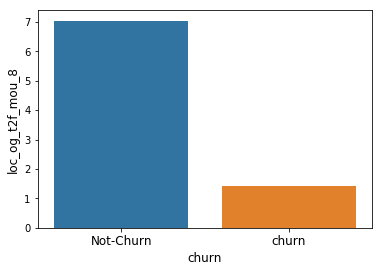

loc_og_t2c_mou_8


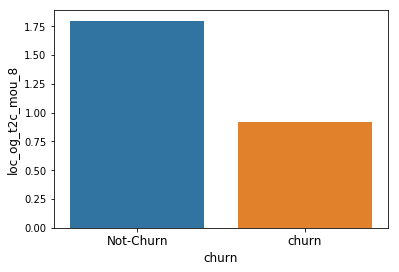

loc_og_mou_8


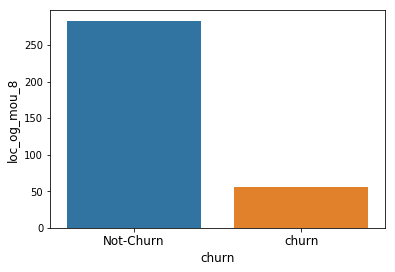

std_og_t2t_mou_8


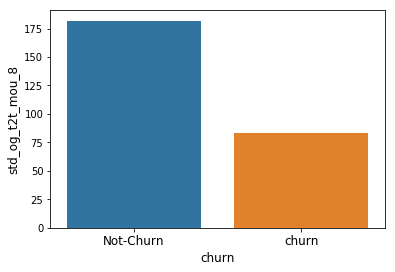

std_og_t2m_mou_8


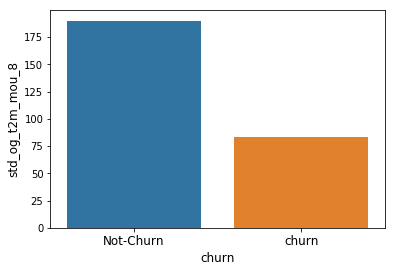

std_og_t2f_mou_8


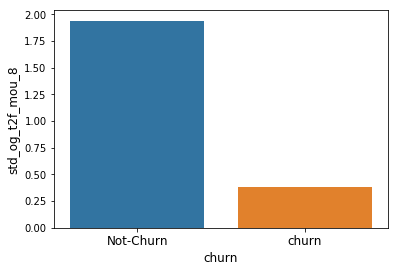

std_og_mou_8


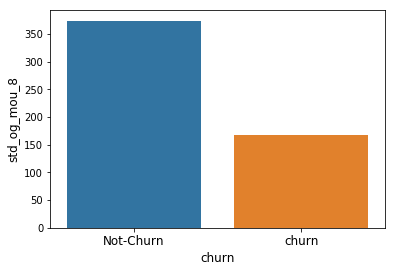

isd_og_mou_8


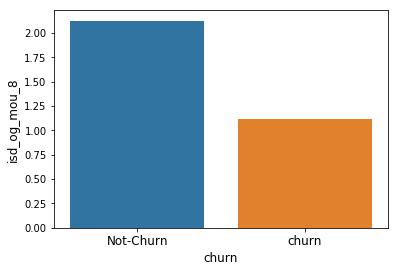

spl_og_mou_8


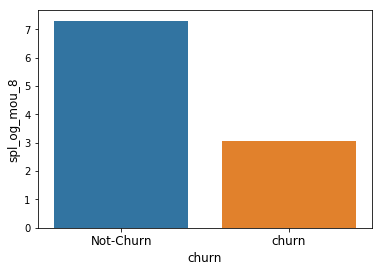

og_others_8


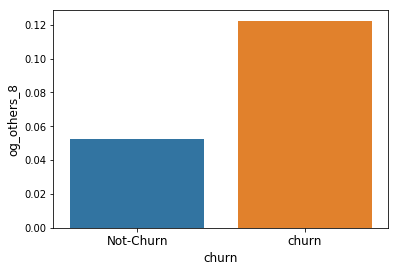

total_og_mou_8


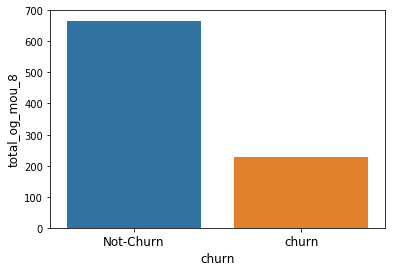

loc_ic_t2t_mou_8


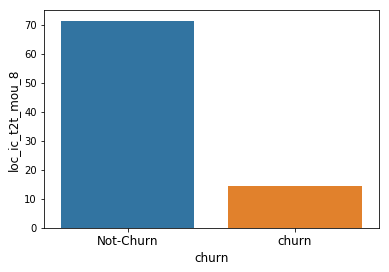

loc_ic_t2m_mou_8


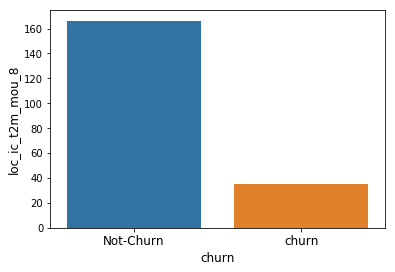

loc_ic_t2f_mou_8


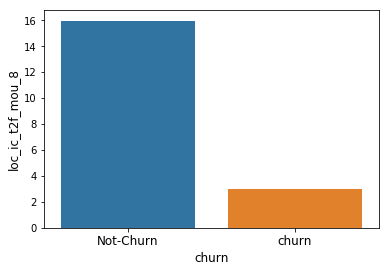

loc_ic_mou_8


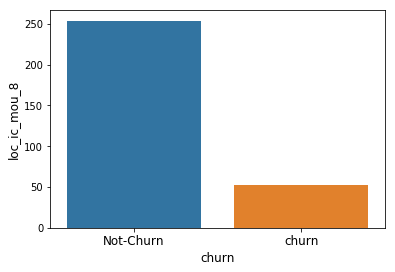

std_ic_t2t_mou_8


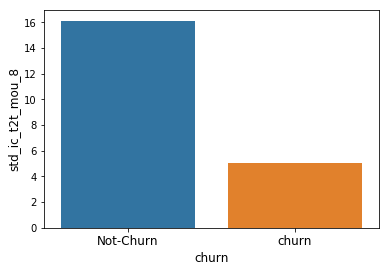

std_ic_t2m_mou_8


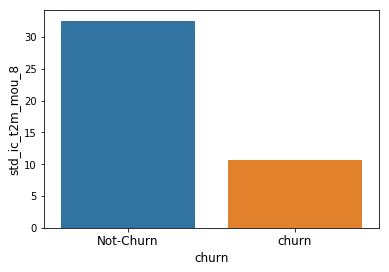

std_ic_t2f_mou_8


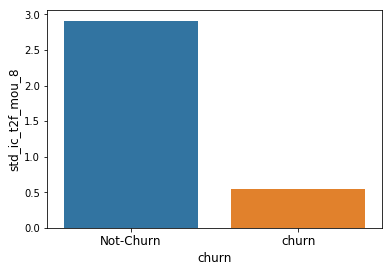

std_ic_mou_8


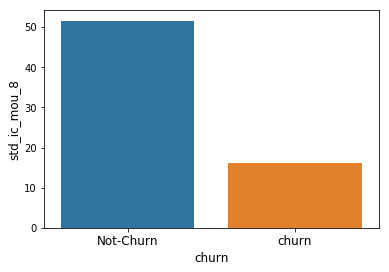

total_ic_mou_8


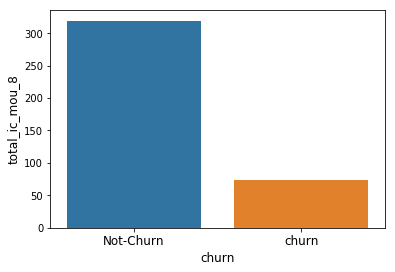

spl_ic_mou_8


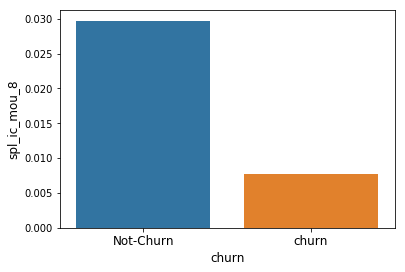

isd_ic_mou_8


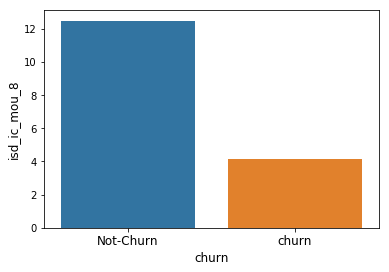

ic_others_8


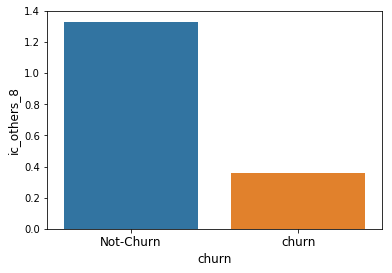

total_rech_num_8


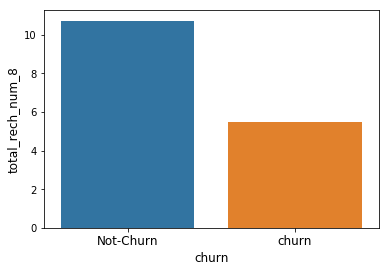

total_rech_amt_8


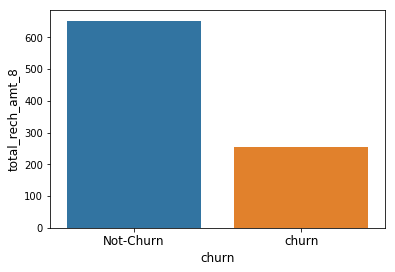

max_rech_amt_8


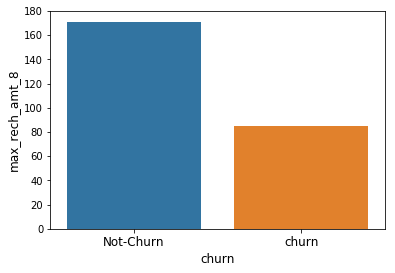

last_day_rch_amt_8


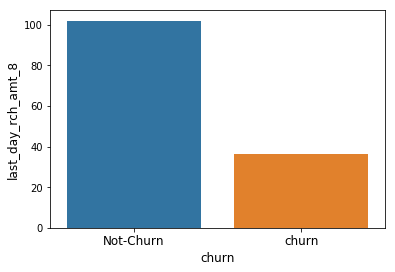

vol_2g_mb_8


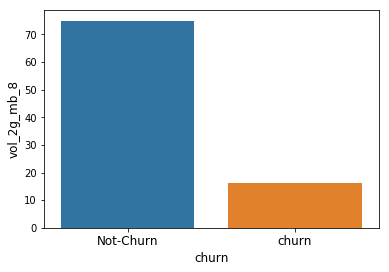

vol_3g_mb_8


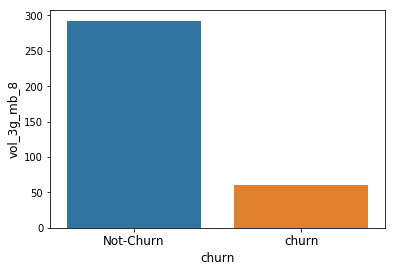

monthly_2g_8


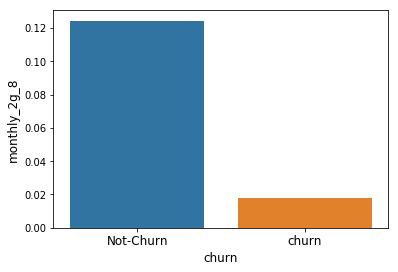

sachet_2g_8


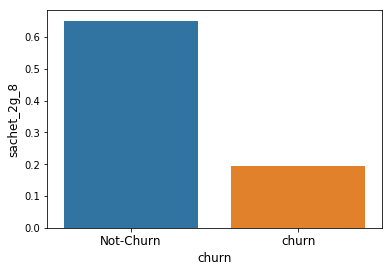

monthly_3g_8


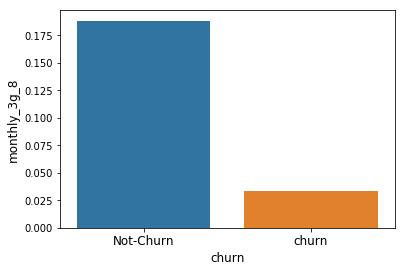

sachet_3g_8


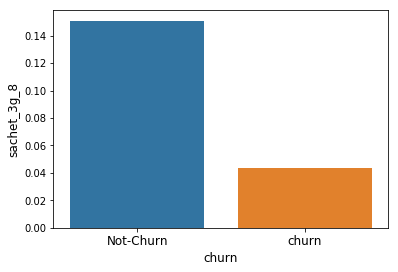

aug_vbc_3g


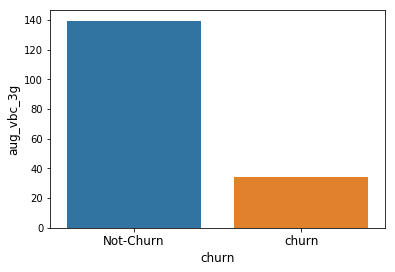

days_from_LastRechage_8


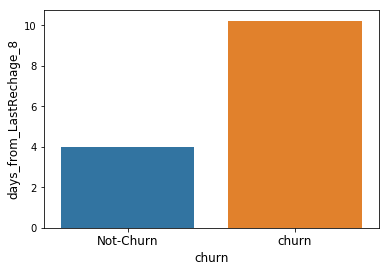

In [541]:
#EDA For Month8 Columns
plotCategoricalChurn_NotChurn(df, column_Month_8)

#### * EDA For Month 6 Month 7 ``Feature Average Value`` (Good Period)

arpu_goodPeriod_Avg


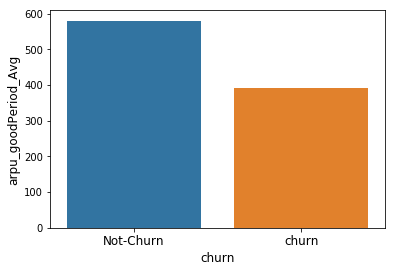

onnet_mou_goodPeriod_Avg


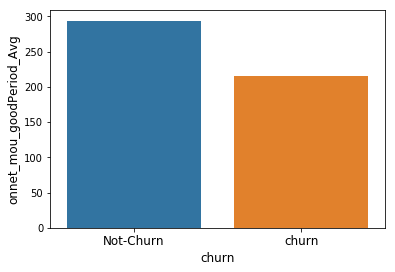

offnet_mou_goodPeriod_Avg


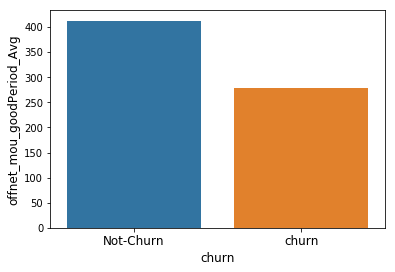

roam_ic_mou_goodPeriod_Avg


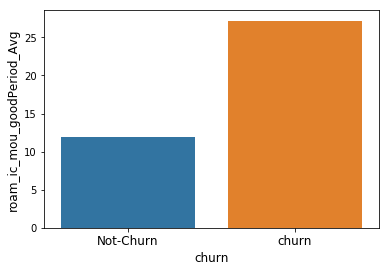

roam_og_mou_goodPeriod_Avg


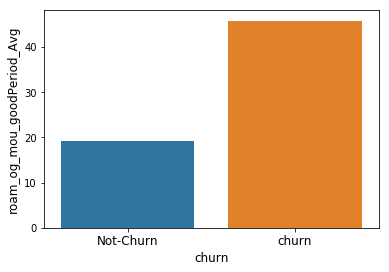

loc_og_t2t_mou_goodPeriod_Avg


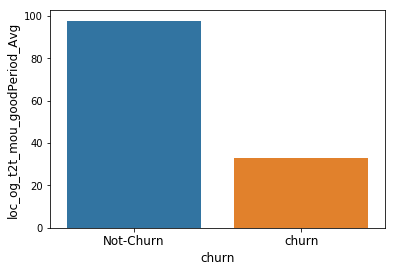

loc_og_t2m_mou_goodPeriod_Avg


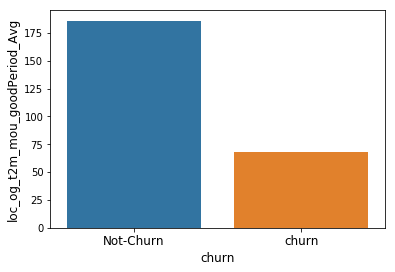

loc_og_t2f_mou_goodPeriod_Avg


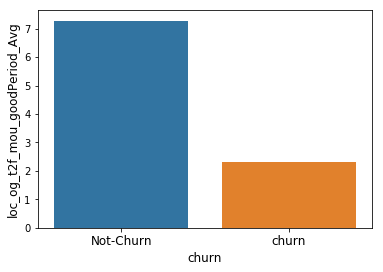

loc_og_t2c_mou_goodPeriod_Avg


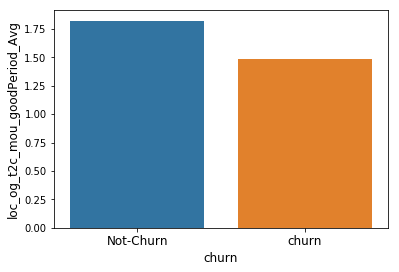

loc_og_mou_goodPeriod_Avg


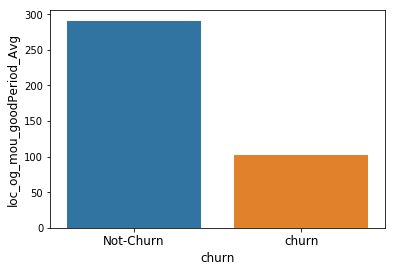

std_og_t2t_mou_goodPeriod_Avg


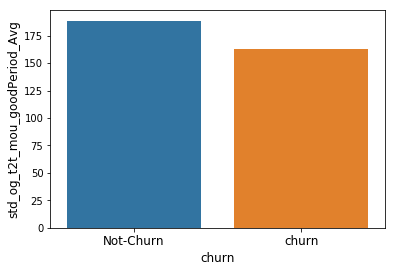

std_og_t2m_mou_goodPeriod_Avg


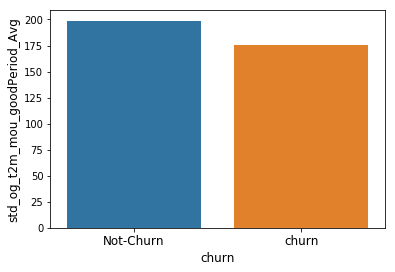

std_og_t2f_mou_goodPeriod_Avg


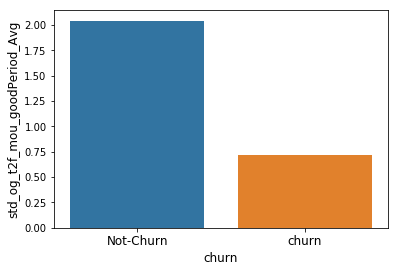

std_og_mou_goodPeriod_Avg


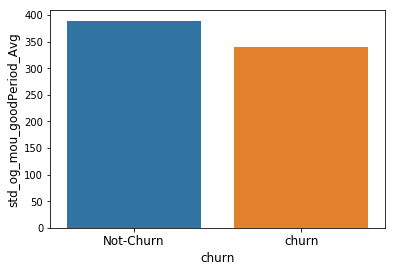

isd_og_mou_goodPeriod_Avg


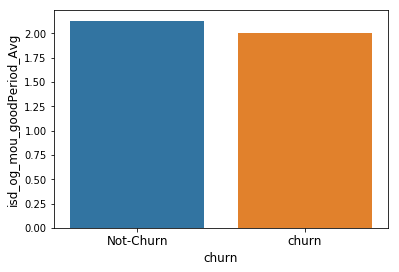

spl_og_mou_goodPeriod_Avg


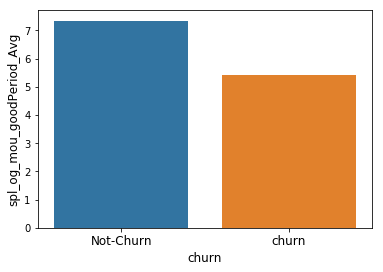

og_others_goodPeriod_Avg


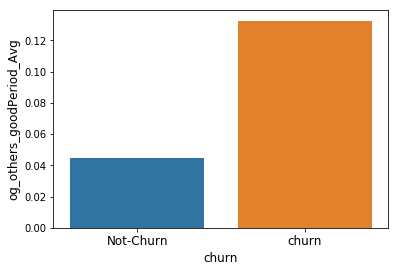

total_og_mou_goodPeriod_Avg


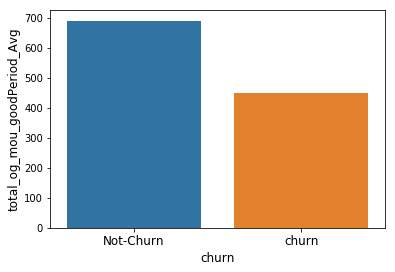

loc_ic_t2t_mou_goodPeriod_Avg


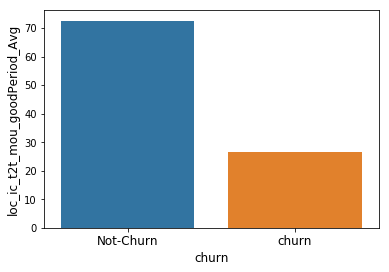

loc_ic_t2m_mou_goodPeriod_Avg


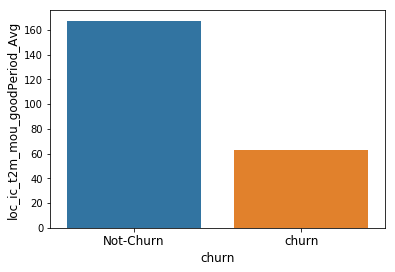

loc_ic_t2f_mou_goodPeriod_Avg


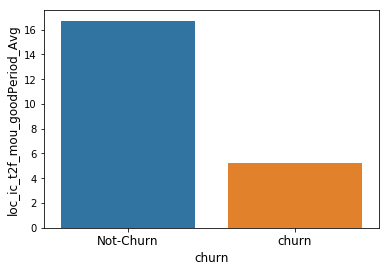

loc_ic_mou_goodPeriod_Avg


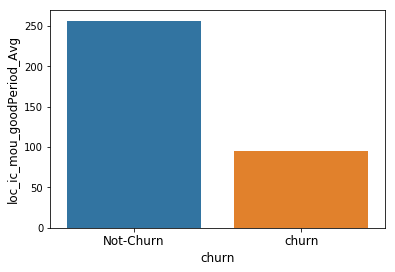

std_ic_t2t_mou_goodPeriod_Avg


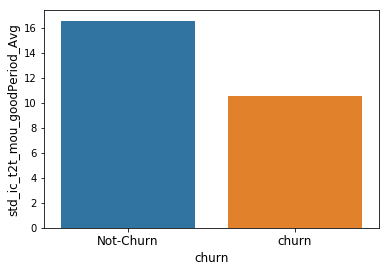

std_ic_t2m_mou_goodPeriod_Avg


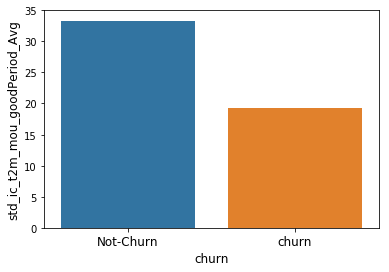

std_ic_t2f_mou_goodPeriod_Avg


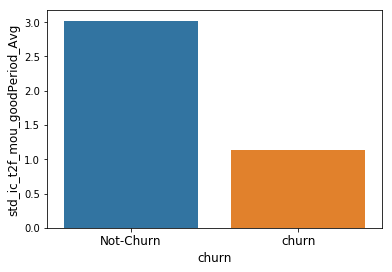

std_ic_mou_goodPeriod_Avg


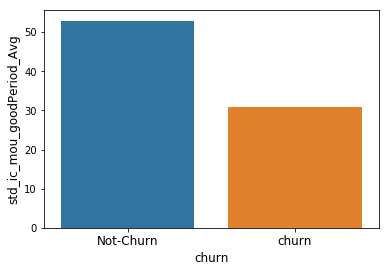

total_ic_mou_goodPeriod_Avg


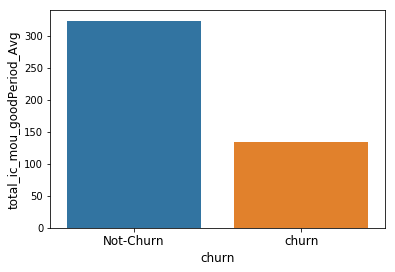

spl_ic_mou_goodPeriod_Avg


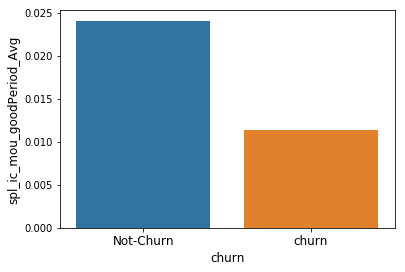

isd_ic_mou_goodPeriod_Avg


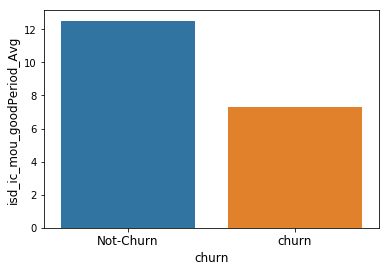

ic_others_goodPeriod_Avg


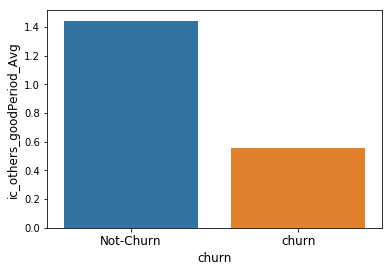

total_rech_num_goodPeriod_Avg


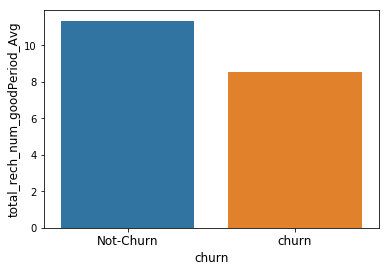

total_rech_amt_goodPeriod_Avg


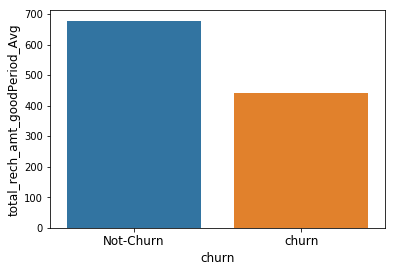

max_rech_amt_goodPeriod_Avg


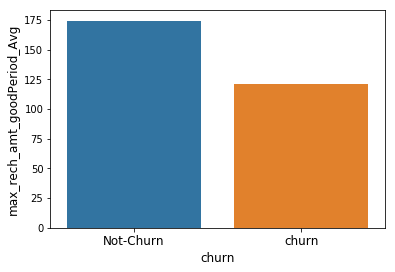

last_day_rch_amt_goodPeriod_Avg


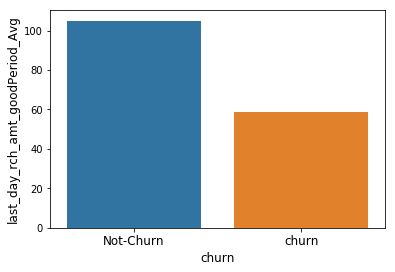

vol_2g_mb_goodPeriod_Avg


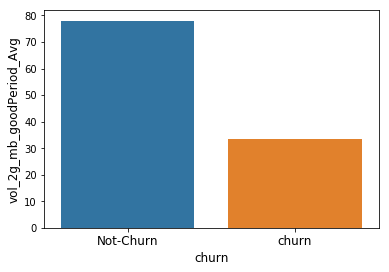

vol_3g_mb_goodPeriod_Avg


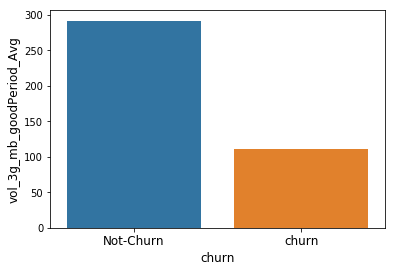

monthly_2g_goodPeriod_Avg


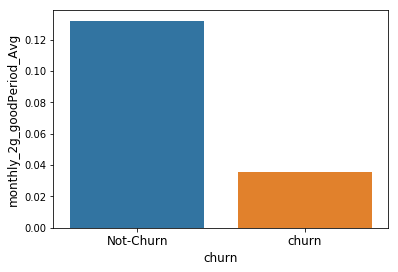

sachet_2g_goodPeriod_Avg


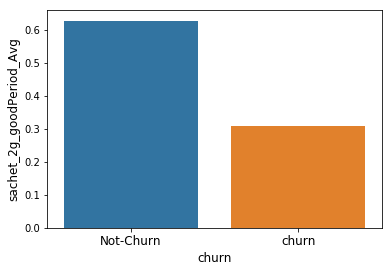

monthly_3g_goodPeriod_Avg


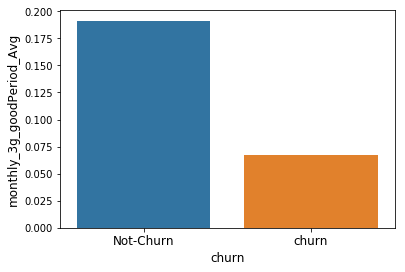

sachet_3g_goodPeriod_Avg


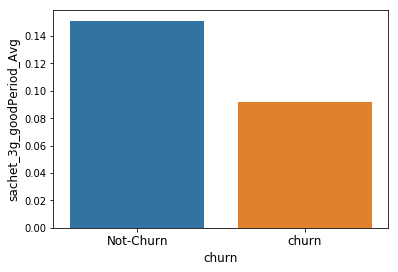

KeyError: 'Column not found: aug_vbc_37'

In [543]:
#EDA For Month 6 Month 7 Value Average
plotCategoricalChurn_NotChurn(df, column_Month_8 , flag=1)